[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/qubvel/segmentation_models.pytorch/blob/main/examples/binary_segmentation_intro.ipynb)

🇭 🇪 🇱 🇱 🇴 👋

This example shows how to use `segmentation-models-pytorch` for **binary** semantic segmentation. We will use the [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (this is an adopted example from Albumentations package [docs](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/), which is strongly recommended to read, especially if you never used this package for augmentations before). 

The task will be to classify each pixel of an input image either as pet 🐶🐱 or as a background.


What we are going to overview in this example:  

 - 📜 `Datasets` and `DataLoaders` preparation (with predefined dataset class).  
 - 📦 `LightningModule` preparation: defining training, validation and test routines.  
 - 📈 Writing `IoU` metric inside the `LightningModule` for measuring quality of segmentation.  
 - 🐶 Results visualization.


> It is expected you are familiar with Python, PyTorch and have some experience with training neural networks before!

In [1]:
%%capture
!pip install -U git+https://github.com/qubvel-org/segmentation_models.pytorch
!pip install lightning albumentations
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118


In [2]:
import os

import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import pandas as pd

C:\Users\Mouse\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


## Dataset

In [3]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch
import multiprocessing

from PIL import Image
from torch.utils.data import DataLoader
from multiprocessing import freeze_support

In [4]:
class YoloDataset_original(Dataset):
    """YOLO Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        data_dir (str): path to the directory containing images and YOLO annotations
        classes (list): list of class names
        augmentation (albumentations.Compose): data transformation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. normalization, shape manipulation, etc.)
    """
    
    def __init__(self, data_dir, classes=None, mode="train", transform=None):
        self.data_dir = data_dir
        self.images_dir = os.path.join(data_dir, mode, "images")
        self.labels_dir = os.path.join(data_dir, mode, "labels")
        self.ids = [os.path.splitext(file)[0] for file in os.listdir(self.images_dir) if file.endswith('.tif')]
        self.images_fps = [os.path.join(self.images_dir, image_id + '.tif') for image_id in self.ids]
        self.annotations_fps = [os.path.join(self.labels_dir, image_id + '.txt') for image_id in self.ids]
        self.classes = classes
        self.class_values = {cls: idx + 1 for idx, cls in enumerate(classes)}  # class IDs start from 1
        
        self.mode = mode
        self.transform = transform
    
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        filename = self.ids[idx]
        image_path = os.path.join(self.images_dir, filename + ".tif")
        annotation_path = os.path.join(self.labels_dir, filename + ".txt")
        image = np.array(Image.open(image_path).convert("RGB"))
        h, w, _ = image.shape
        mask = self._read_annotation(annotation_path, w, h)

        result = dict(image=image, mask=mask, filename=filename)  # Include filename
        if self.transform is not None:
            result = self.transform(**result)

        # resize images
        image = np.array(
            Image.fromarray(result["image"]).resize((512, 512), Image.BILINEAR)
        )
        if result["mask"] is not None:
            mask = np.array(
                Image.fromarray(result["mask"]).resize((512, 512), Image.NEAREST)
            )
            result["mask"] = np.expand_dims(mask, 0)
        else:
            result["mask"] = np.zeros((1, 512, 512), dtype=np.uint8)

        # convert to other format HWC -> CHW
        result["image"] = np.moveaxis(image, -1, 0)

        return result

    def _read_annotation(self, annotation_path, img_width, img_height):
        if not os.path.exists(annotation_path):
            return None
        
        mask = np.zeros((img_height, img_width), dtype=np.uint8)
        with open(annotation_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 3:
                    print(f"Skipping invalid annotation line: {line}")
                    continue
                
                class_id = int(parts[0]) + 1
                coords = list(map(float, parts[1:]))
                if len(coords) % 2 != 0:
                    print(f"Skipping invalid coordinate line: {line}")
                    continue
                
                coords = np.array(coords).reshape(-1, 2)
                
                # Denormalize the coordinates
                coords[:, 0] *= img_width
                coords[:, 1] *= img_height
                
                # Create a mask from the polygon
                coords = coords.astype(np.int32)
                cv2.fillPoly(mask, [coords], class_id)
        

        return mask

In [5]:
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

## Model

In [6]:
import os
import torch
import torch.optim as optim
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchmetrics.classification import BinaryPrecision, BinaryRecall

In [7]:
# Some training hyperparameters
EPOCHS = 100 #set epochs!
OUT_CLASSES = 1

In [8]:
class SegModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, encoder_weights, in_channels, out_classes, **kwargs):
        super().__init__()
        self.save_hyperparameters
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameters for image
        params = smp.encoders.get_preprocessing_params(encoder_name, encoder_weights)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))
        self.training_step_outputs = []
        self.validing_step_outputs = []
        self.testing_step_outputs = []

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        
        # Metrics
        self.precision = BinaryPrecision(threshold=0.5)
        self.recall = BinaryRecall(threshold=0.5)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        
        image = batch["image"]
        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4
        # Check that image dimensions are divisible by 32, 
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]
        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0
        
        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)
        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()
        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        self.training_step_outputs.append({
            "loss": loss.detach(),  # Ensure loss is detached
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
            "pred_mask": pred_mask,
            "mask": mask
        })
        return loss

    def on_train_epoch_end(self):
        tp = torch.cat([x["tp"] for x in self.training_step_outputs])
        fp = torch.cat([x["fp"] for x in self.training_step_outputs])
        fn = torch.cat([x["fn"] for x in self.training_step_outputs])
        tn = torch.cat([x["tn"] for x in self.training_step_outputs])
        pred_masks = torch.cat([x["pred_mask"] for x in self.training_step_outputs])
        masks = torch.cat([x["mask"] for x in self.training_step_outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        # Calculate precision and recall
        precision = self.precision(pred_masks, masks)
        recall = self.recall(pred_masks, masks)

        # Calculate mAP@50
        map50 = (precision * recall).mean().item()

        # Log the metrics
        avg_loss = torch.stack([x["loss"] for x in self.training_step_outputs]).mean()
        self.log('tr_loss', avg_loss, prog_bar=True,on_epoch=True)
        self.log('tr_image_iou', per_image_iou, prog_bar=True,on_epoch=True)
        self.log('tr_dataset_iou', dataset_iou, prog_bar=True,on_epoch=True)
        self.log('tr_map50', map50, prog_bar=True,on_epoch=True)
        self.training_step_outputs.clear()  # free memory

    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4
        # Check that image dimensions are divisible by 32, 
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]
        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4
        
        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0
              

        logits_mask = self.forward(image)
           

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)


        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        # Calculate precision and recall
        precision = self.precision(pred_mask, mask)
        recall = self.recall(pred_mask, mask)

        # Calculate mAP@50
        map50 = (precision * recall).mean().item()        
        self.log('val_loss', loss, prog_bar=True,on_epoch=True)
        self.log('val_map50', map50, prog_bar=True,on_epoch=True)
        

    
    def test_step(self, batch, batch_idx):
        image = batch["image"]
        filenames = batch["filename"]  # Extract filenames

        # Shape of the image should be (batch_size, num_channels, height, width)
        assert image.ndim == 4
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]
        assert mask.ndim == 4
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        loss = self.loss_fn(logits_mask, mask)

        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # Compute additional stats for evaluation
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        # Calculate precision and recall
        precision = self.precision(pred_mask, mask)
        recall = self.recall(pred_mask, mask)

        # Calculate mAP@50
        map50 = (precision * recall).mean().item()

        # Log filenames and metrics
        for i, filename in enumerate(filenames):
            print(f"Filename: {filename}, Loss: {loss.item()}, mAP@50: {map50}")

        self.log('test_loss', loss, prog_bar=True, on_epoch=True)
        self.log('test_map50', map50, prog_bar=True, on_epoch=True)



    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        return optimizer


    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=16,
            shuffle=True,
            num_workers=os.cpu_count(),
            persistent_workers=True,
            drop_last=True  # Ensures each batch is the same size
        )

    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset,
            batch_size=16,
            shuffle=False,
            num_workers=os.cpu_count(),
            persistent_workers=True,
            drop_last=False
        )


    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=16,
            shuffle=False,
            num_workers=os.cpu_count(),
            persistent_workers=True,
            drop_last=False,
            collate_fn=lambda x: {key: [d[key] for d in x] for key in x[0]}  # Collate into dictionary
        )

In [9]:
import numpy as np
import torch
import random

# Set the random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [10]:
model = SegModel("specify architecture", "specify encoder", encoder_weights='specify encoder weights (i.e. imagenet)', in_channels=3, out_classes=1)

## Training

In [20]:
DATA_DIR = './path to dataset'
image_height, image_width = 512, 512 #specify image size
CLASSES = ['cell']

In [21]:
train_dataset = YoloDataset_original(DATA_DIR, mode="train", classes=CLASSES)
valid_dataset = YoloDataset_original(DATA_DIR, mode="val", classes=CLASSES)
test_dataset = YoloDataset_original(DATA_DIR, mode="test", classes=CLASSES)

In [22]:
print(len(train_dataset))

188


In [23]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [24]:
# Check if filenames are included in the dataset
for batch_idx, batch in enumerate(train_loader):
    print(f"Batch {batch_idx}: {batch.keys()}")  # Print keys in the batch dictionary
    if "filename" in batch:
        print("Filenames are included in the dataset!")
    else:
        print("Filenames are NOT included in the dataset.")
    break  # Check only the first batch to avoid long output

Batch 0: dict_keys(['image', 'mask', 'filename'])
Filenames are included in the dataset!


In [25]:
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)

trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params
----------------------------------------------
0 | model     | Unet            | 23.8 M
1 | loss_fn   | DiceLoss        | 0     
2 | precision | BinaryPrecision | 0     
3 | recall    | BinaryRecall    | 0     
----------------------------------------------
23.8 M    Trainable params
0         Non-trainable params
23.8 M    Total params
95.027    Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\Mouse\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
C:\Users\Mouse\anaconda3\Lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
C:\Users\Mouse\anaconda3\Lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 9. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
C:\Users\Mouse\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increas

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.


## Validation and test metrics

In [26]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_loader, verbose=False)
print(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                                                                    | 0/? [00:00<…

[{'val_loss': 0.9008312821388245, 'val_map50': 0.24908943474292755}]


In [27]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Mouse\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |                                                                                       | 0/? [00:00<…

Filename: DRG_4_0_0, Loss: 0.0, mAP@50: 0.0
Filename: DRG_4_0_1000, Loss: 0.0, mAP@50: 0.0
Filename: DRG_4_0_1500, Loss: 0.0, mAP@50: 0.0
Filename: DRG_4_0_2000, Loss: 0.0, mAP@50: 0.0
Filename: DRG_4_0_2500, Loss: 0.0, mAP@50: 0.0
Filename: DRG_4_0_3000, Loss: 0.0, mAP@50: 0.0
Filename: DRG_4_0_500, Loss: 0.0, mAP@50: 0.0
Filename: DRG_4_1000_0, Loss: 0.0, mAP@50: 0.0
Filename: DRG_4_1000_1000, Loss: 0.0, mAP@50: 0.0
Filename: DRG_4_1000_1500, Loss: 0.0, mAP@50: 0.0
Filename: DRG_4_1000_2000, Loss: 0.0, mAP@50: 0.0
Filename: DRG_4_1000_2500, Loss: 0.0, mAP@50: 0.0
Filename: DRG_4_1000_3000, Loss: 0.0, mAP@50: 0.0
Filename: DRG_4_1000_500, Loss: 0.0, mAP@50: 0.0
Filename: DRG_4_1500_0, Loss: 0.0, mAP@50: 0.0
Filename: DRG_4_1500_1000, Loss: 0.0, mAP@50: 0.0
Filename: DRG_4_1500_1500, Loss: 0.0, mAP@50: 0.0
Filename: DRG_4_1500_2000, Loss: 0.0, mAP@50: 0.0
Filename: DRG_4_1500_2500, Loss: 0.0, mAP@50: 0.0
Filename: DRG_4_1500_3000, Loss: 0.0, mAP@50: 0.0
Filename: DRG_4_1500_500, Loss: 

C:\Users\Mouse\anaconda3\Lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 13. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


# Save model to HF Hub

Login to [HF hub](https://huggingface.co/) if you want to save your model to the hub. Then, you will be able to save and load model, save metrics, and dataset name!

In [28]:
trainer.save_checkpoint("path to save model")


In [29]:
loaded_model = SegModel.load_from_checkpoint(
    checkpoint_path=r"path to save model",
    arch="specify architecture",                     # Required argument for SegModel    
    encoder_name="specify encoder",             # Required argument for SegModel
    encoder_weights='specify encoder weights',       # Required argument for SegModel
    in_channels=3,                    # Required argument for SegModel
    out_classes=1                     # Required argument for SegModel
)


C:\Users\Mouse\anaconda3\Lib\site-packages\lightning_fabric\utilities\cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


## Run prediction and save the prediction files

In [31]:
import numpy as np
import os
import torch

# Create the output directory if it does not exist
binary_pr_masks_threshold = 0.8 #set threshold
output_dir = r"path to output for prediction outputs"
os.makedirs(output_dir, exist_ok=True)

# Iterate over the test_loader to process the entire dataset
for batch_idx, batch in enumerate(test_loader):
    # Get the list of original filenames (assuming 'filename' key exists in batch)
    if "filename" in batch:
        filenames = batch["filename"]  # Original filenames from the batch
    else:
        filenames = [f"image_{batch_idx * len(batch['image']) + i}" for i in range(len(batch["image"]))]

    with torch.no_grad():
        loaded_model.eval()
        logits = loaded_model(batch["image"])  # Output raw logits

    # Convert logits to probabilities using sigmoid
    pr_masks = logits.sigmoid().cpu().numpy()  # Convert to NumPy array
    binary_pr_masks = (pr_masks > binary_pr_masks_threshold).astype(np.float32)  # Apply threshold and convert to binary NumPy array

    # Save pr_masks and binary_pr_masks as individual NumPy arrays using original filenames
    for i, filename in enumerate(filenames):
        # Ensure the filename has no extension
        base_filename = os.path.splitext(filename)[0]

        # Extract the individual masks
        individual_pr_mask = np.squeeze(pr_masks[i])  # Shape will be (H, W) after squeezing
        individual_binary_pr_mask = np.squeeze(binary_pr_masks[i])  # Shape will be (H, W)

        # Save the individual masks as separate NumPy files
        np.save(os.path.join(output_dir, f"{base_filename}_pr_mask.npy"), individual_pr_mask)
        np.save(os.path.join(output_dir, f"{base_filename}_binary_pr_mask.npy"), individual_binary_pr_mask)

    print(f"Batch {batch_idx + 1} processed and saved.")

print("All predictions have been saved as separate NumPy files.")


Batch 1 processed and saved.
Batch 2 processed and saved.
Batch 3 processed and saved.
Batch 4 processed and saved.
Batch 5 processed and saved.
All predictions have been saved as separate NumPy files.


#### Print and check the saved npy file 

In [21]:
#prints a specific npy file to check
import numpy as np

# Load the .npy file
file_path = "path to a specific prediction output"  # Replace with the path to your .npy file
data = np.load(file_path)

# Print the contents of the .npy file
print("Data in the .npy file:")
print(data)


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Mouse/Desktop/segmentation_model_outputs/updated/Unet_vgg16_bn/image_13_pr_mask.npy'

# Result visualization

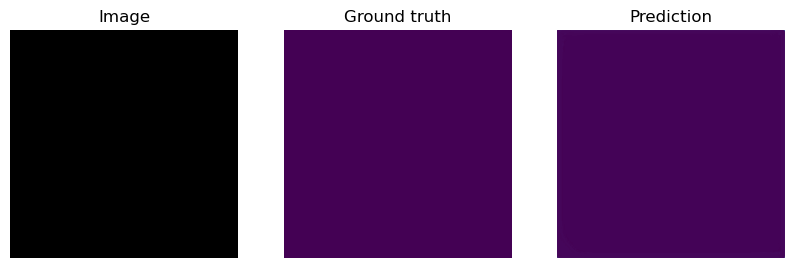

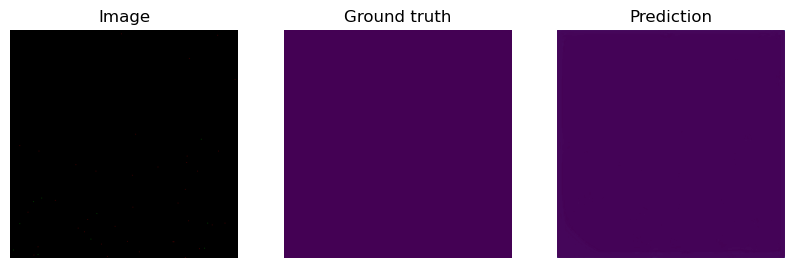

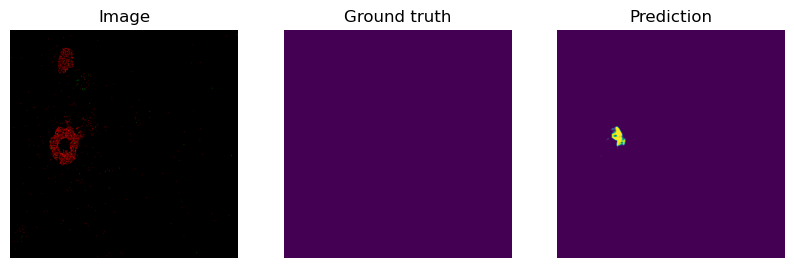

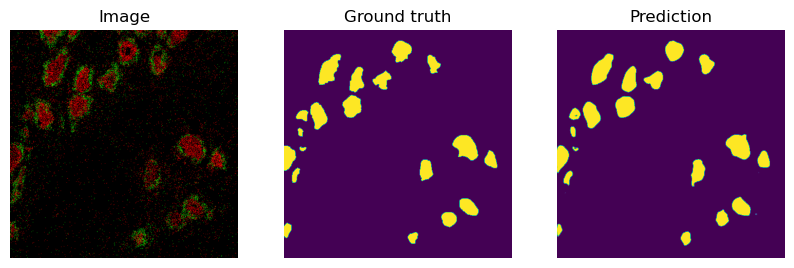

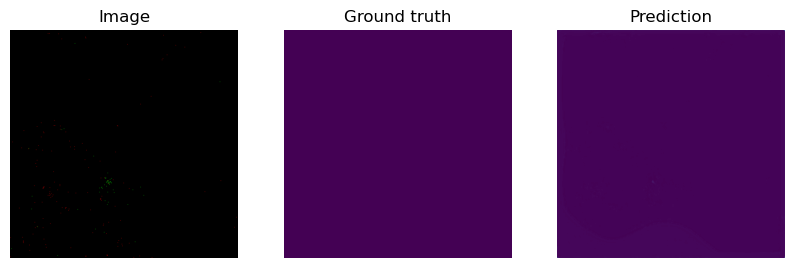

In [415]:
batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(
    zip(batch["image"], batch["mask"], pr_masks)
):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break

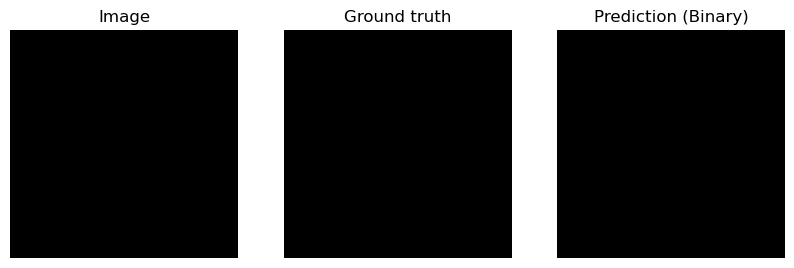

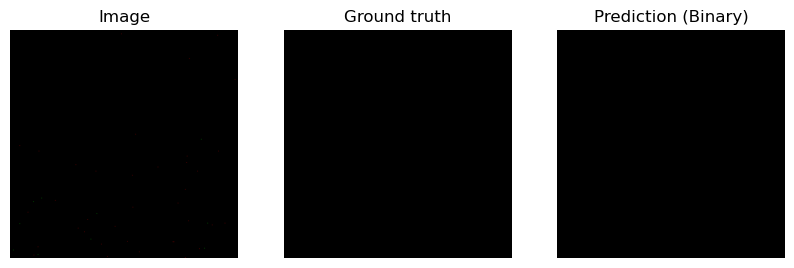

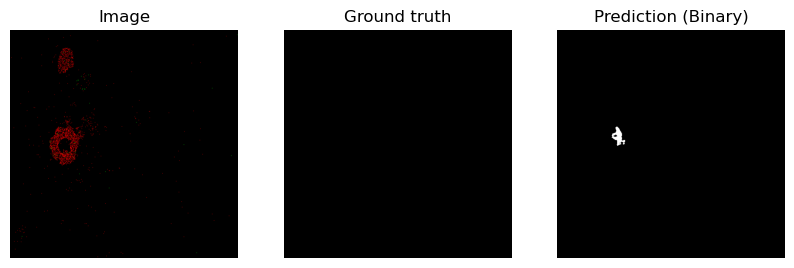

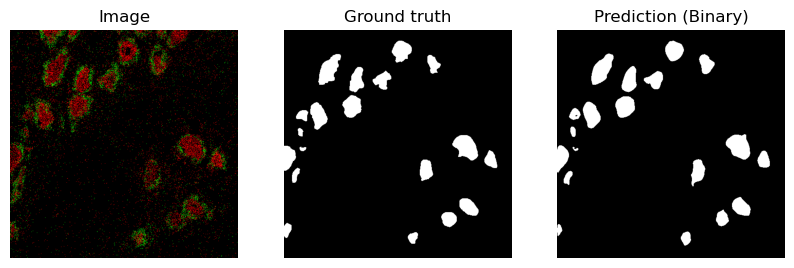

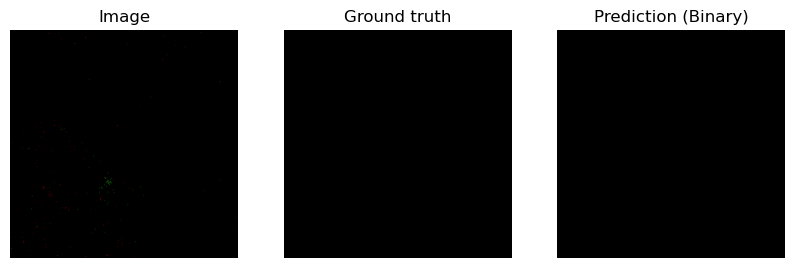

In [416]:
batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])  # Output raw logits

# Convert logits to probabilities using sigmoid
pr_masks = logits.sigmoid()

# Apply a threshold to convert the probabilities into binary values (0 or 1)
binary_pr_masks = (pr_masks > 0.8).float()  # Threshold at 0.5

# Visualization
for idx, (image, gt_mask, pr_mask) in enumerate(
    zip(batch["image"], batch["mask"], binary_pr_masks)  # Use the binary masks for visualization
):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))  # Transpose to [H, W, C] for visualization
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze(), cmap="gray")  # Ground truth mask
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze(), cmap="gray")  # Predicted binary mask
        plt.title("Prediction (Binary)")
        plt.axis("off")
        plt.show()

